In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1599.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1588.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1089.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1282.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_0838.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1109.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_0379.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_0160.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1527.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_2492.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1112.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_0823.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1898.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_0926.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_0477.jpg
/kaggle/input/drowsyface4/resizeOutput/noYawn/noYawn_1810.jpg
/kaggle/

In [2]:
import os
import shutil
import random

# Đường dẫn thư mục gốc 
root_dir = "/kaggle/input/drowsyface4/resizeOutput"

# Đường dẫn thư mục đầu ra
output_base = "/kaggle/working/datasetsplit"

# Lấy danh sách các lớp ảnh từ thư mục gốc và chuyển về lowercase
original_classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
classes = [c.lower() for c in original_classes]

# Tạo các thư mục train, val, test cùng các thư mục con cho từng lớp
for subset in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_base, subset, cls), exist_ok=True)

# Đặt seed để việc chia dữ liệu ngẫu nhiên có thể tái lập
random.seed(42)

# Với mỗi lớp ảnh, tiến hành chia dữ liệu và sao chép ảnh
for orig_cls in original_classes:
    cls = orig_cls.lower()  # tên lớp ở dạng lowercase cho thư mục đích
    src_folder = os.path.join(root_dir, orig_cls)     # thư mục nguồn (theo tên gốc)
    # Lấy toàn bộ danh sách file ảnh của lớp và xáo trộn ngẫu nhiên
    filenames = os.listdir(src_folder)
    random.shuffle(filenames)
    # Tính toán chỉ số phân chia
    total = len(filenames)
    train_idx = int(0.8 * total)
    val_idx = int(0.95 * total)
    # Chia danh sách file thành 3 phần
    train_files = filenames[:train_idx]
    val_files   = filenames[train_idx:val_idx]
    test_files  = filenames[val_idx:]
    # Sao chép file vào thư mục tương ứng
    for fname in train_files:
        src_path = os.path.join(src_folder, fname)
        dst_path = os.path.join(output_base, "train", cls, fname)
        shutil.copy(src_path, dst_path)
    for fname in val_files:
        src_path = os.path.join(src_folder, fname)
        dst_path = os.path.join(output_base, "val", cls, fname)
        shutil.copy(src_path, dst_path)
    for fname in test_files:
        src_path = os.path.join(src_folder, fname)
        dst_path = os.path.join(output_base, "test", cls, fname)
        shutil.copy(src_path, dst_path)


In [3]:
import os, random
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [4]:
# -------- Configuration --------
DATA_ROOT = '/kaggle/working/datasetsplit'
BATCH_SIZE = 32
INPUT_SIZE = 224
EPOCHS = 15
LR = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BACKBONES = ['vgg16','mobilenet_v2','mobilenet_v3_small','efficientnet_b0']
CLASS_NAMES = ['closed','open','no_yawn','yawn']
METRICS_CSV = 'multitask_metrics.csv'


In [5]:
# -------- Data Augmentation --------
aug_train = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomResizedCrop(INPUT_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
aug_eval = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [6]:
# --- DataLoaders for train/val/test ---
loaders = {}
for phase in ['train','val','test']:
    path = os.path.join(DATA_ROOT, phase)
    ds = datasets.ImageFolder(path, transform=(aug_train if phase=='train' else aug_eval))
    loader = DataLoader(ds, batch_size=BATCH_SIZE,
                        shuffle=(phase=='train'), num_workers=4)
    loaders[phase] = loader

In [7]:
# --- Multi-Task Model ---
class MultiTaskNet(nn.Module):
    """
    Shared backbone + two classification heads:
      - eye: open/closed
      - mouth: no_yawn/yawn
    """
    def __init__(self, backbone_name):
        super().__init__()
        # Load backbone
        if backbone_name=='vgg16':
            base = models.vgg16_bn(pretrained=True)
            self.feature = base.features
            feat_dim = 512
        elif backbone_name=='mobilenet_v2':
            base = models.mobilenet_v2(pretrained=True)
            self.feature = base.features
            feat_dim = base.classifier[1].in_features
        elif backbone_name=='mobilenet_v3_small':
            base = models.mobilenet_v3_small(pretrained=True)
            self.feature = base.features
            feat_dim = base.classifier[0].in_features
        elif backbone_name=='efficientnet_b0':
            base = models.efficientnet_b0(pretrained=True)
            self.feature = base.features
            feat_dim = base.classifier[1].in_features
        else:
            raise ValueError(f"Unsupported {backbone_name}")
        # Freeze backbone
        for p in self.feature.parameters(): p.requires_grad=False
        # Pooling
        self.pool = nn.AdaptiveAvgPool2d(1)
        # Heads
        self.eye_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim,256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256,2)
        )
        self.mouth_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim,256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256,2)
        )

    def forward(self, x):
        f = self.feature(x)
        f = self.pool(f)
        return self.eye_head(f), self.mouth_head(f)


In [8]:
all_results = []
for backbone in BACKBONES:
    print(f"*** Backbone: {backbone} ***")
    model = MultiTaskNet(backbone).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)
    best_val_acc = 0.0
    best_wt = None

    # Train/Validation loop
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        eye_corr = mouth_corr = eye_tot = mouth_tot = 0
        for imgs, labels in loaders['train']:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            el, ml = model(imgs)
            loss = torch.tensor(0.0, device=DEVICE)
            # Eye branch (labels 0,1)
            mask_e = labels < 2
            if mask_e.any():
                le = criterion(el[mask_e], labels[mask_e])
                loss += le
                preds = el[mask_e].argmax(dim=1)
                eye_corr += (preds == labels[mask_e]).sum().item()
                eye_tot += labels[mask_e].size(0)
            # Mouth branch (labels 2,3)
            mask_m = labels >= 2
            if mask_m.any():
                lm = criterion(ml[mask_m], labels[mask_m] - 2)
                loss += lm
                preds = ml[mask_m].argmax(dim=1)
                mouth_corr += (preds == labels[mask_m] - 2).sum().item()
                mouth_tot += (labels[mask_m] - 2).size(0)
            loss.backward()
            optimizer.step()
        train_acc = (eye_corr + mouth_corr) / (eye_tot + mouth_tot)

        # Validation phase
        model.eval()
        ve_corr = vm_corr = ve_tot = vm_tot = 0
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in loaders['val']:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                el, ml = model(imgs)
                # Eye
                me = labels < 2
                if me.any():
                    le = criterion(el[me], labels[me])
                    val_loss += le.item() * me.sum().item()
                    p = el[me].argmax(dim=1)
                    ve_corr += (p == labels[me]).sum().item()
                    ve_tot += me.sum().item()
                # Mouth
                mm = labels >= 2
                if mm.any():
                    lm = criterion(ml[mm], labels[mm] - 2)
                    val_loss += lm.item() * mm.sum().item()
                    p = ml[mm].argmax(dim=1)
                    vm_corr += (p == labels[mm] - 2).sum().item()
                    vm_tot += mm.sum().item()
        val_acc = (ve_corr + vm_corr) / (ve_tot + vm_tot)
        scheduler.step(val_loss)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_wt = model.state_dict()
        print(f"Epoch {epoch+1}/{EPOCHS} | train_acc: {train_acc:.4f} | val_acc: {val_acc:.4f}")

    # Save best model
    model.load_state_dict(best_wt)
    torch.save(model.state_dict(), f"multitask_{backbone}.pth")

    # Test evaluation
    model.eval()
    ys_e = []; ps_e = []
    ys_m = []; ps_m = []
    with torch.no_grad():
        for imgs, labels in loaders['test']:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            el, ml = model(imgs)
            me = labels < 2
            if me.any():
                ys_e.extend(labels[me].cpu().numpy())
                ps_e.extend(el[me].argmax(dim=1).cpu().numpy())
            mm = labels >= 2
            if mm.any():
                ys_m.extend((labels[mm] - 2).cpu().numpy())
                ps_m.extend(ml[mm].argmax(dim=1).cpu().numpy())
    rep_e = classification_report(ys_e, ps_e, target_names=['closed','open'], output_dict=True)
    rep_m = classification_report(ys_m, ps_m, target_names=['no_yawn','yawn'], output_dict=True)
    print("Eye report: ", classification_report(ys_e, ps_e, target_names=['closed','open']))
    print("Mouth report: ", classification_report(ys_m, ps_m, target_names=['no_yawn','yawn']))

    # Collect results
    all_results.append({
        'model': backbone,
        'eye_f1': rep_e['macro avg']['f1-score'],
        'mouth_f1': rep_m['macro avg']['f1-score']
    })

# Write out CSV once
import pandas as pd
df = pd.DataFrame(all_results)
df.to_csv(METRICS_CSV, index=False)
print("All results:")
print(df)


*** Backbone: vgg16 ***


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 224MB/s]


Epoch 1/15 | train_acc: 0.8786 | val_acc: 0.9753
Epoch 2/15 | train_acc: 0.9613 | val_acc: 0.9833
Epoch 3/15 | train_acc: 0.9633 | val_acc: 0.9847
Epoch 4/15 | train_acc: 0.9735 | val_acc: 0.9860
Epoch 5/15 | train_acc: 0.9751 | val_acc: 0.9860
Epoch 6/15 | train_acc: 0.9790 | val_acc: 0.9880
Epoch 7/15 | train_acc: 0.9808 | val_acc: 0.9880
Epoch 8/15 | train_acc: 0.9786 | val_acc: 0.9893
Epoch 9/15 | train_acc: 0.9801 | val_acc: 0.9887
Epoch 10/15 | train_acc: 0.9822 | val_acc: 0.9893
Epoch 11/15 | train_acc: 0.9832 | val_acc: 0.9893
Epoch 12/15 | train_acc: 0.9840 | val_acc: 0.9853
Epoch 13/15 | train_acc: 0.9839 | val_acc: 0.9907
Epoch 14/15 | train_acc: 0.9848 | val_acc: 0.9880
Epoch 15/15 | train_acc: 0.9872 | val_acc: 0.9893
Eye report:                precision    recall  f1-score   support

      closed       0.99      1.00      1.00       125
        open       1.00      0.99      1.00       125

    accuracy                           1.00       250
   macro avg       1.00     

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 135MB/s]


Epoch 1/15 | train_acc: 0.9246 | val_acc: 0.9693
Epoch 2/15 | train_acc: 0.9694 | val_acc: 0.9760
Epoch 3/15 | train_acc: 0.9751 | val_acc: 0.9820
Epoch 4/15 | train_acc: 0.9761 | val_acc: 0.9793
Epoch 5/15 | train_acc: 0.9795 | val_acc: 0.9833
Epoch 6/15 | train_acc: 0.9809 | val_acc: 0.9840
Epoch 7/15 | train_acc: 0.9815 | val_acc: 0.9847
Epoch 8/15 | train_acc: 0.9865 | val_acc: 0.9847
Epoch 9/15 | train_acc: 0.9858 | val_acc: 0.9873
Epoch 10/15 | train_acc: 0.9868 | val_acc: 0.9873
Epoch 11/15 | train_acc: 0.9848 | val_acc: 0.9847
Epoch 12/15 | train_acc: 0.9866 | val_acc: 0.9840
Epoch 13/15 | train_acc: 0.9845 | val_acc: 0.9860
Epoch 14/15 | train_acc: 0.9870 | val_acc: 0.9873
Epoch 15/15 | train_acc: 0.9854 | val_acc: 0.9807


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


Eye report:                precision    recall  f1-score   support

      closed       0.98      0.99      0.99       125
        open       0.99      0.98      0.99       125

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250

Mouth report:                precision    recall  f1-score   support

     no_yawn       0.98      1.00      0.99       125
        yawn       1.00      0.98      0.99       125

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250

*** Backbone: mobilenet_v3_small ***


100%|██████████| 9.83M/9.83M [00:00<00:00, 148MB/s]


Epoch 1/15 | train_acc: 0.9236 | val_acc: 0.9340
Epoch 2/15 | train_acc: 0.9735 | val_acc: 0.9680
Epoch 3/15 | train_acc: 0.9806 | val_acc: 0.9880
Epoch 4/15 | train_acc: 0.9835 | val_acc: 0.9967
Epoch 5/15 | train_acc: 0.9858 | val_acc: 0.9947
Epoch 6/15 | train_acc: 0.9892 | val_acc: 0.9940
Epoch 7/15 | train_acc: 0.9855 | val_acc: 0.9947
Epoch 8/15 | train_acc: 0.9900 | val_acc: 0.9953
Epoch 9/15 | train_acc: 0.9908 | val_acc: 0.9960
Epoch 10/15 | train_acc: 0.9891 | val_acc: 0.9967
Epoch 11/15 | train_acc: 0.9900 | val_acc: 0.9973
Epoch 12/15 | train_acc: 0.9909 | val_acc: 0.9953
Epoch 13/15 | train_acc: 0.9904 | val_acc: 0.9960
Epoch 14/15 | train_acc: 0.9904 | val_acc: 0.9960
Epoch 15/15 | train_acc: 0.9900 | val_acc: 0.9960


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Eye report:                precision    recall  f1-score   support

      closed       0.99      0.99      0.99       125
        open       0.99      0.99      0.99       125

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250

Mouth report:                precision    recall  f1-score   support

     no_yawn       1.00      0.99      1.00       125
        yawn       0.99      1.00      1.00       125

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

*** Backbone: efficientnet_b0 ***


100%|██████████| 20.5M/20.5M [00:00<00:00, 181MB/s]


Epoch 1/15 | train_acc: 0.9269 | val_acc: 0.9840
Epoch 2/15 | train_acc: 0.9718 | val_acc: 0.9880
Epoch 3/15 | train_acc: 0.9804 | val_acc: 0.9873
Epoch 4/15 | train_acc: 0.9818 | val_acc: 0.9907
Epoch 5/15 | train_acc: 0.9844 | val_acc: 0.9913
Epoch 6/15 | train_acc: 0.9858 | val_acc: 0.9913
Epoch 7/15 | train_acc: 0.9878 | val_acc: 0.9927
Epoch 8/15 | train_acc: 0.9840 | val_acc: 0.9933
Epoch 9/15 | train_acc: 0.9864 | val_acc: 0.9933
Epoch 10/15 | train_acc: 0.9881 | val_acc: 0.9940
Epoch 11/15 | train_acc: 0.9865 | val_acc: 0.9927
Epoch 12/15 | train_acc: 0.9878 | val_acc: 0.9940
Epoch 13/15 | train_acc: 0.9876 | val_acc: 0.9920
Epoch 14/15 | train_acc: 0.9895 | val_acc: 0.9947
Epoch 15/15 | train_acc: 0.9889 | val_acc: 0.9940
Eye report:                precision    recall  f1-score   support

      closed       0.99      0.99      0.99       125
        open       0.99      0.99      0.99       125

    accuracy                           0.99       250
   macro avg       0.99     

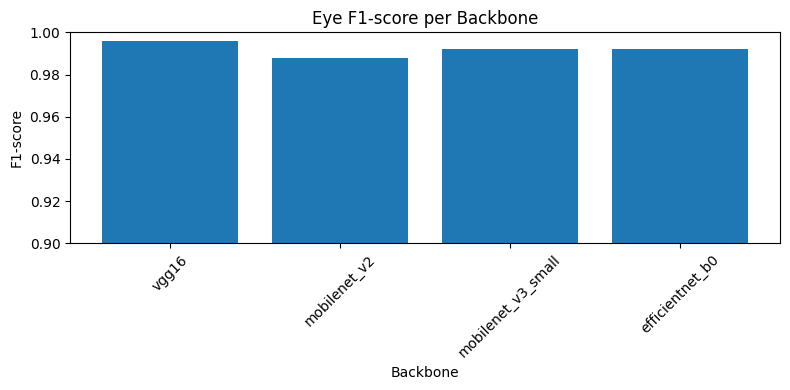

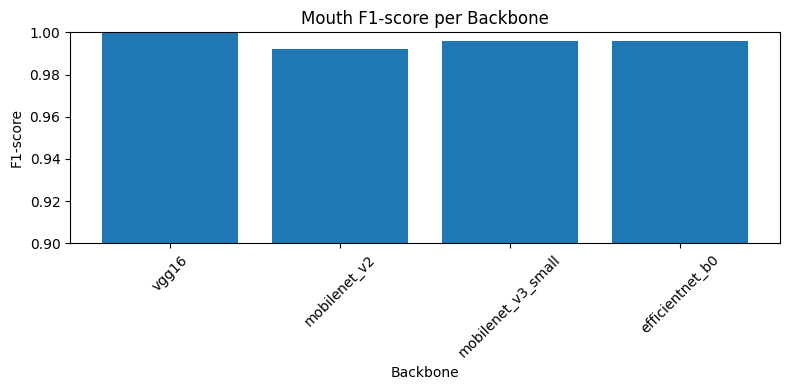

In [9]:
import matplotlib.pyplot as plt
df = pd.read_csv(METRICS_CSV)

plt.figure(figsize=(8,4))
plt.bar(df['model'], df['eye_f1'])
plt.title('Eye F1-score per Backbone')
plt.ylim(0.9,1.0)
plt.xlabel('Backbone'); plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(df['model'], df['mouth_f1'])
plt.title('Mouth F1-score per Backbone')
plt.ylim(0.9,1.0)
plt.xlabel('Backbone'); plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# =====================
# Evaluation Diagrams
# =====================
# 1. Bar charts of F1-scores
import seaborn as sns

plt.figure(figsize=(8,4))
plt.bar(df['model'], df['eye_f1'], label='Eye F1')
plt.ylim(0,1.0)
plt.title('Eye F1-score per Backbone')
plt.xlabel('Backbone')
plt.ylabel('F1-score')
plt.tight_layout()
plt.savefig('eye_f1_scores.png')
plt.close()

plt.figure(figsize=(8,4))
plt.bar(df['model'], df['mouth_f1'], label='Mouth F1', color='tab:orange')
plt.ylim(0,1.0)
plt.title('Mouth F1-score per Backbone')
plt.xlabel('Backbone')
plt.ylabel('F1-score')
plt.tight_layout()
plt.savefig('mouth_f1_scores.png')
plt.close()

# 2. Confusion matrices heatmaps for each backbone
for backbone, res in zip(df['model'], all_results):
    # Reload model weights and evaluate confusion matrices
    model = MultiTaskNet(backbone).to(DEVICE)
    model.load_state_dict(torch.load(f"multitask_{backbone}.pth"))
    model.eval()
    ys_e, ps_e, ys_m, ps_m = [], [], [], []
    with torch.no_grad():
        for imgs, labels in loaders['test']:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            el, ml = model(imgs)
            me = labels < 2
            if me.any():
                ys_e.extend(labels[me].cpu().numpy())
                ps_e.extend(el[me].argmax(dim=1).cpu().numpy())
            mm = labels >= 2
            if mm.any():
                ys_m.extend((labels[mm]-2).cpu().numpy())
                ps_m.extend(ml[mm].argmax(dim=1).cpu().numpy())
    cm_e = confusion_matrix(ys_e, ps_e)
    cm_m = confusion_matrix(ys_m, ps_m)
    # Eye CM
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_e, annot=True, fmt='d', cmap='Blues',
                xticklabels=['closed','open'], yticklabels=['closed','open'])
    plt.title(f'Eye CM - {backbone}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'cm_eye_{backbone}.png')
    plt.close()
    # Mouth CM
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_m, annot=True, fmt='d', cmap='Greens',
                xticklabels=['no_yawn','yawn'], yticklabels=['no_yawn','yawn'])
    plt.title(f'Mouth CM - {backbone}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'cm_mouth_{backbone}.png')
    plt.close()

print('Evaluation diagrams saved: eye_f1_scores.png, mouth_f1_scores.png, cm_eye_*.png, cm_mouth_*.png')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depreca

Evaluation diagrams saved: eye_f1_scores.png, mouth_f1_scores.png, cm_eye_*.png, cm_mouth_*.png
